Notebook based on https://github.com/c-hofer/topologically_densified_distributions/blob/master/core/experiments.py

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import random
import torch.nn as nn
import torch.optim as optim
from modules.cnn import SimpleCNN13
from utils.tensor_ops import set_seed
from pathlib import Path
import matplotlib.pyplot as plt
from utils.topo_ds import *
import seaborn as sns 
from utils.pershom import pers2fn
import numpy as np

CHECKPOINT_PATH = Path('./saved_models/cnn_topo')
DATASET_PATH =  Path("./data")
FIG_PATH =  Path("./Visualization/cnn_topo")

set_seed(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Data

In [83]:
def multi_draw_collate_fn(batch):
    data=[]
    for x in batch[0][0]:
        data.append(x[None, :])

    data = torch.cat(data, dim=0)
    return  data

In [85]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip()])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128
num_subset = 500
trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                        download=True, transform=transform_train)
trainset = torch.utils.data.Subset(trainset, random.sample(range(len(trainset)), num_subset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          pin_memory=True,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False,
                                       download=True, transform=transform_test)


ds_test_multi = IntraLabelMultiDraw(testset, 16)
testloader = (DataLoader(testset,
                         num_workers=2,
                         batch_size=batch_size,
                         shuffle=False
                         ),
              
              DataLoader(ds_test_multi,
                         num_workers=4,
                         collate_fn=multi_draw_collate_fn,
                         batch_size=1,
                         shuffle=False
                )
              )



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Train


In [59]:
net = SimpleCNN13(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
            [
                {'params': net.parameters(), 'weight_decay': 0.001},
            ],
            lr=0.5,
            momentum=0.9,
            nesterov=True)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=310,
            eta_min=0,
            last_epoch=-1)

net.train()
net.to(device)

for epoch in tqdm(range(310), leave=False, desc="Training"):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        print(inputs.shape)
        break
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()

Training:   0%|                                                                        | 0/310 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25fcc7fa70>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f25fcc7fa70>Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process  File "/opt/conda/lib/python3.7/site-p

KeyboardInterrupt: 

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f25fcc7fa70>self._shutdown_workers()

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()    
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    AssertionError: can only test a child processassert self._parent_pid == os.getpid(), 'can only tes

In [ ]:
torch.save(net.state_dict(), CHECKPOINT_PATH / f"cifar10_{num_subset}.pth")

# Test




In [60]:
net = SimpleCNN13(len(classes))
net.load_state_dict(torch.load(CHECKPOINT_PATH / f"cifar10_{num_subset}.pth"))

<All keys matched successfully>

In [61]:
correct = 0
total = 0
net.to(device)
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    dataloader = testloader[0]
    for data in dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs, _ = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


Computing: 100%|████████████████████████████████████████████████████████| 10000/10000 [01:34<00:00, 105.92it/s]


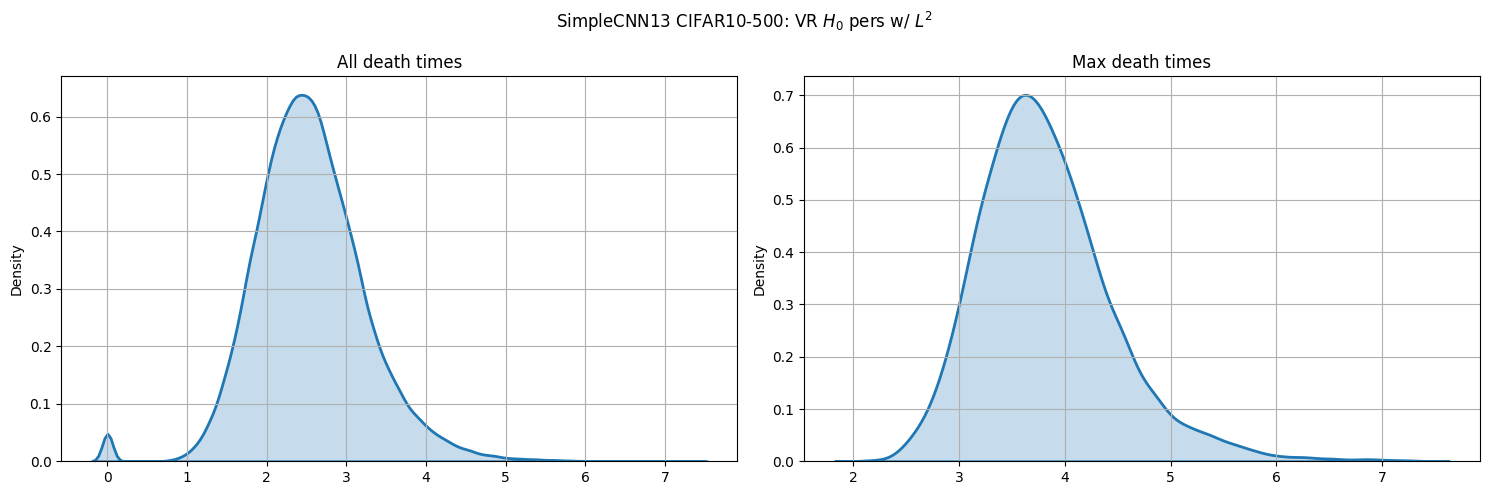

In [88]:
net.to(device)
net.eval()
pers_fn = pers2fn("L_2")

pre_topo = []
pre_topo_max = []
with torch.no_grad():
    dataloader = testloader[1]
    for inputs in tqdm(dataloader, position=0, leave=True, desc="Computing"):
        inputs = inputs.to(device)
        _, latents = net(inputs)
        aux = pers_fn(latents.contiguous())[0][0][:, 1].tolist()
        pre_topo += aux
        pre_topo_max.append(np.max(aux))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(pre_topo, linewidth=2, fill=True, ax=ax1)
ax1.set_title("All death times")

sns.kdeplot(pre_topo_max, linewidth=2, fill=True, ax=ax2)
ax2.set_title("Max death times")

ax1.grid()
ax2.grid()
fig.suptitle(f"SimpleCNN13 CIFAR10-{num_subset}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$")
plt.tight_layout()
fig.savefig("topo_dist_cnn_cifar10_{num_subset}.png")
plt.show()

In [90]:
0.8/np.mean(pre_topo_max)

0.20939031058300966